<a href="https://www.kaggle.com/code/arunika1/minor-project?scriptVersionId=96057481" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pima-indians-diabetes-database/diabetes.csv


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import pickle

In [3]:
data = pd.read_csv('/kaggle/input/pima-indians-diabetes-database/diabetes.csv')

# Basic EDA and Statistical Analysis

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


## Handling Missing Values
#### Some columns have value 0 which is not possible. These 0s are actually null values

In [6]:
data_copy = data.copy(deep=True)
data_copy[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = data_copy[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0, np.nan)
print(data_copy.isnull().sum())

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


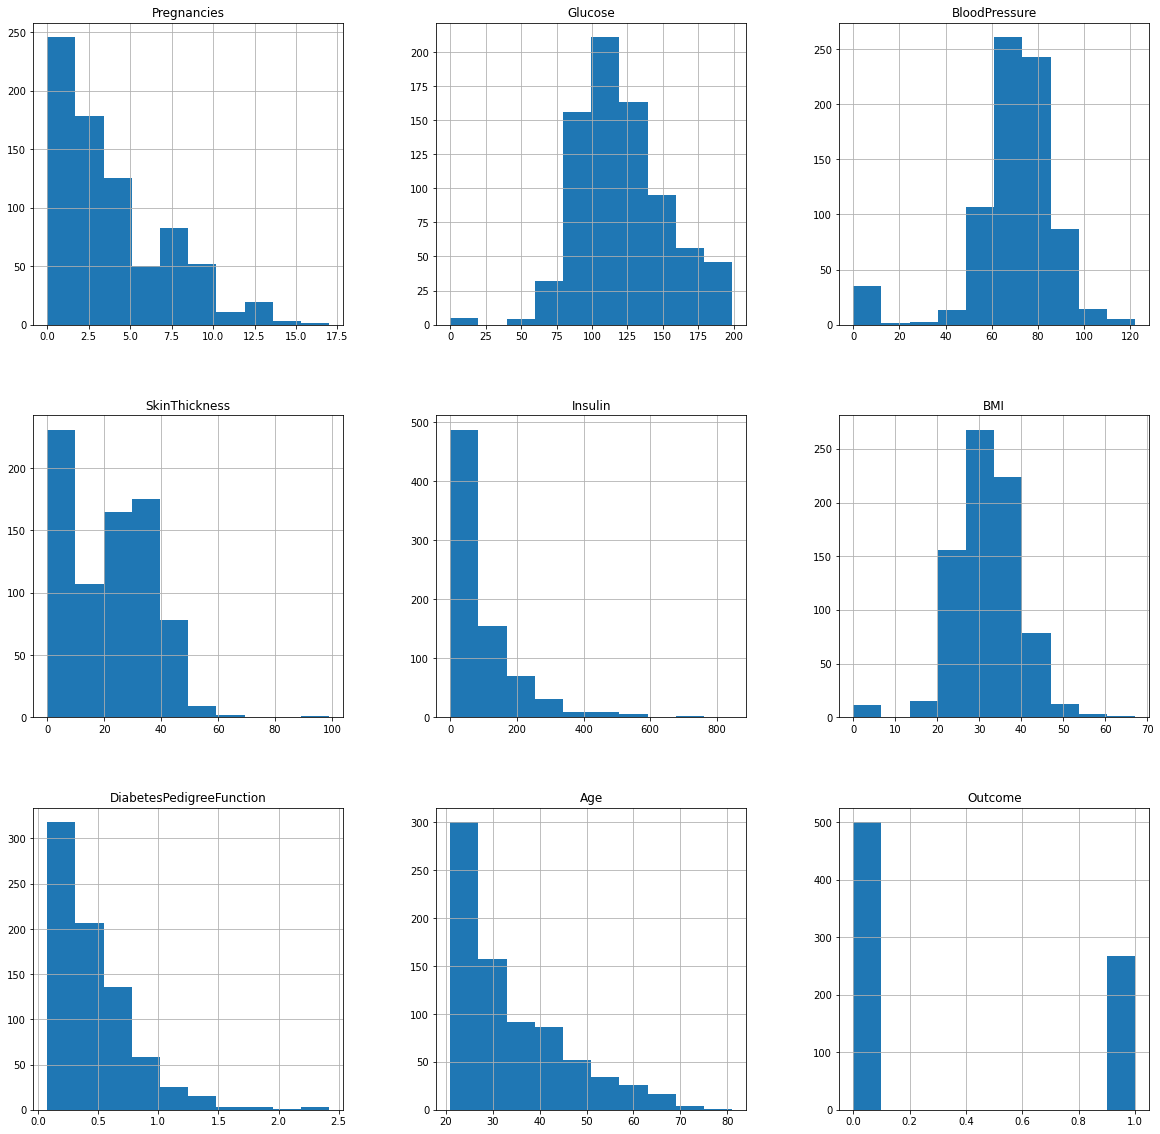

In [7]:
p = data.hist(figsize = (20,20))

In [8]:
data_copy['Glucose'].fillna(data_copy['Glucose'].mean(), inplace = True)
data_copy['BloodPressure'].fillna(data_copy['BloodPressure'].mean(), inplace = True)
data_copy['SkinThickness'].fillna(data_copy['SkinThickness'].median(), inplace = True)
data_copy['Insulin'].fillna(data_copy['Insulin'].mean(), inplace = True)
data_copy['BMI'].fillna(data_copy['BMI'].median(), inplace = True)

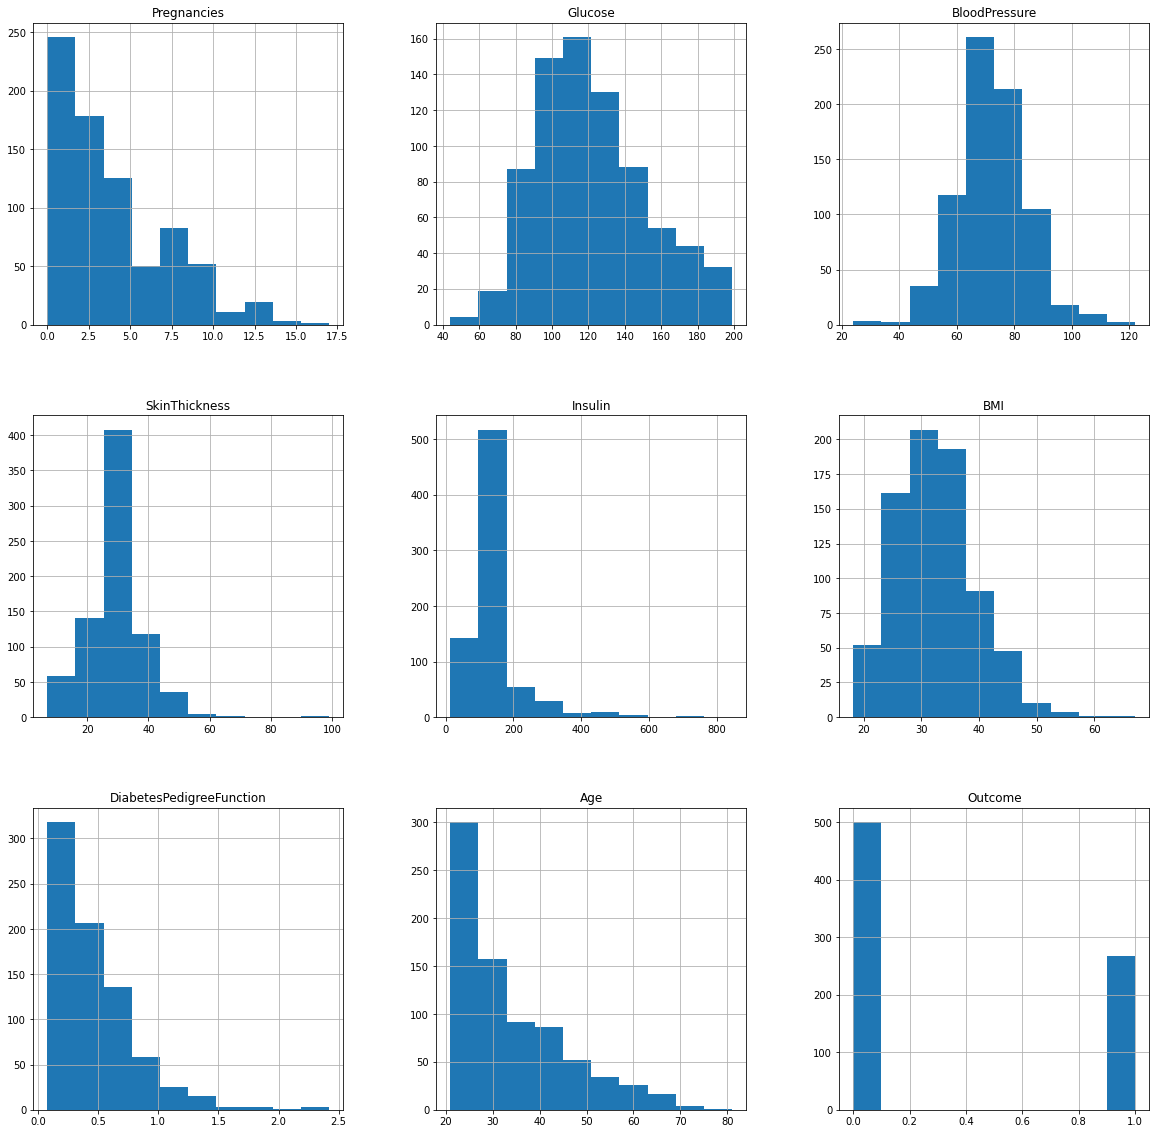

In [9]:
p = data_copy.hist(figsize = (20,20))

## Checking the Correlation between Features

<AxesSubplot:>

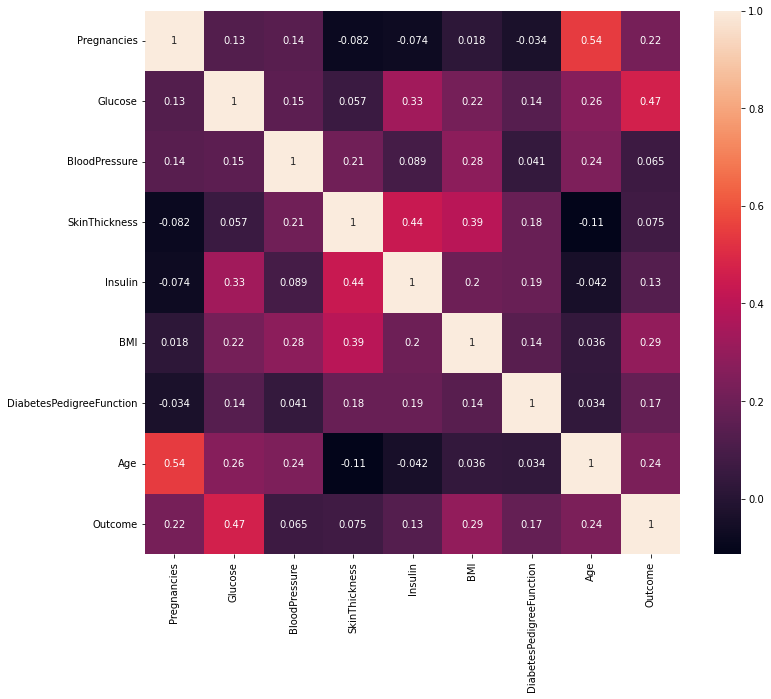

In [10]:
plt.figure(figsize=(12,10))
sns.heatmap(data.corr(), annot=True)

<AxesSubplot:>

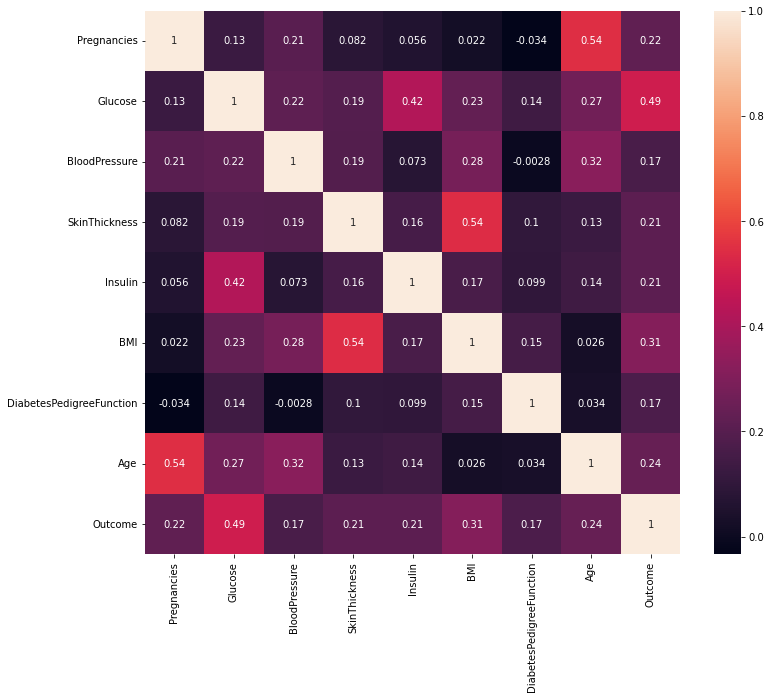

In [11]:
plt.figure(figsize=(12,10))
sns.heatmap(data_copy.corr(), annot=True)

#### We can see from the distribution charts below that **Diabetic** patients seem to have relatively high **Glucose** and **BMI**.

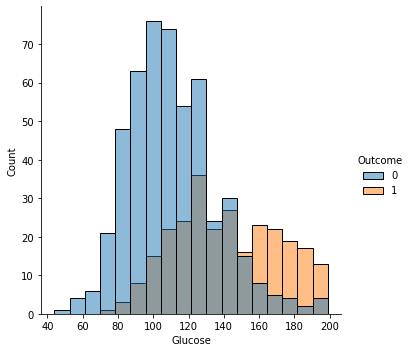

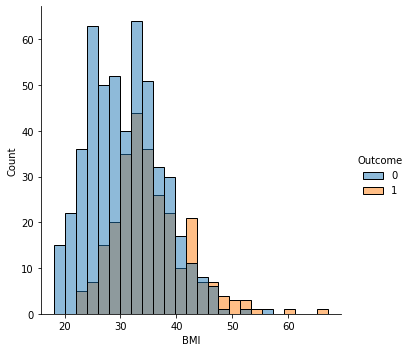

In [12]:
sns.displot(data_copy, x="Glucose", hue='Outcome')
sns.displot(data_copy, x="BMI", hue='Outcome')

In [13]:
data_copy.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.108073,155.548223,32.455208,0.471876,33.240885,0.348958
std,3.369578,30.435949,12.096346,8.791221,85.021108,6.875177,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,121.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.202592,29.000000,155.548223,32.300000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,155.548223,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Splitting the dependent and independent variables.

In [14]:
x = data_copy.drop(['Outcome'],axis=1)
y = data_copy['Outcome']

## Scaling the Data

In [15]:
sc = StandardScaler()
x = pd.DataFrame(sc.fit_transform(x))

In [16]:
x.describe()

,0,1,2,3,4,5,6,7
count,7.680000e+02,7.680000e+02,7.680000e+02,7.680000e+02,7.680000e+02,7.680000e+02,7.680000e+02,7.680000e+02
mean,-6.476301e-17,-3.561966e-16,6.915764e-16,-1.526557e-16,-3.330669e-16,2.613650e-16,2.451743e-16,1.931325e-16
std,1.000652e+00,1.000652e+00,1.000652e+00,1.000652e+00,1.000652e+00,1.000652e+00,1.000652e+00,1.000652e+00
min,-1.141852e+00,-2.554131e+00,-4.004245e+00,-2.516429e+00,-1.665945e+00,-2.074783e+00,-1.189553e+00,-1.041549e+00
25%,-8.448851e-01,-7.212214e-01,-6.953060e-01,-4.675972e-01,-4.007289e-01,-7.212087e-01,-6.889685e-01,-7.862862e-01
50%,-2.509521e-01,-1.540881e-01,-1.675912e-02,-1.230129e-02,-3.345079e-16,-2.258989e-02,-3.001282e-01,-3.608474e-01
75%,6.399473e-01,6.103090e-01,6.282695e-01,3.291706e-01,-3.345079e-16,6.032562e-01,4.662269e-01,6.602056e-01
max,3.906578e+00,2.541850e+00,4.102655e+00,7.955377e+00,8.126238e+00,5.042397e+00,5.883565e+00,4.063716e+00


## Hyperparameter Tuning of the KNN Classifier

In [17]:
x_train, x_val, y_train, y_val = train_test_split(x,y,test_size=0.3,random_state=42,stratify=y)

In [18]:
accuracies = np.zeros(20)
for i in range(1,21):
    #Train Model and Predict  
    knn = KNeighborsClassifier(n_neighbors = i).fit(x_train,y_train)
    y_pred = knn.predict(x_val)
    accuracies[i-1] = metrics.accuracy_score(y_val, y_pred)

accuracies

array([0.72294372, 0.72294372, 0.75757576, 0.75324675, 0.74891775,
       0.74025974, 0.74458874, 0.74458874, 0.72727273, 0.72294372,
       0.75324675, 0.72727273, 0.74025974, 0.73593074, 0.74891775,
       0.72727273, 0.74891775, 0.75757576, 0.75757576, 0.75324675])

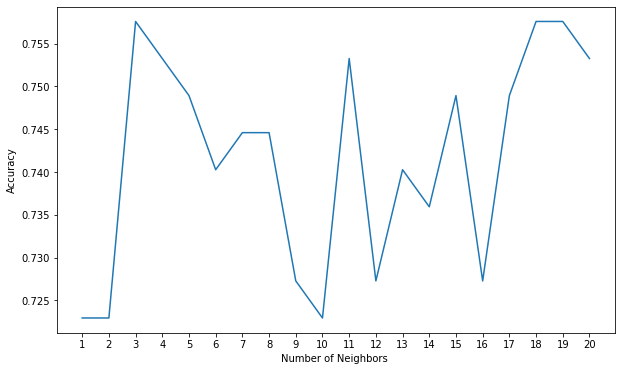

In [19]:
loc = np.arange(1,21,step=1.0)
plt.figure(figsize = (10, 6))
plt.plot(range(1,21), accuracies)
plt.xticks(loc)
plt.xlabel('Number of Neighbors ')
plt.ylabel('Accuracy')
plt.show()

In [20]:
grid_params = { 'n_neighbors' : [int(x) for x in np.linspace(start = 3, stop = 19, num = 9)],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}

In [21]:
gs = GridSearchCV(KNeighborsClassifier(), grid_params, verbose = 1, cv=3, n_jobs = -1)

In [22]:
g_model = gs.fit(x, y)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


In [23]:
g_model.best_params_

{'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'uniform'}

## Building the model with best params

In [24]:
knn = KNeighborsClassifier(n_neighbors=9,weights='uniform',metric='manhattan',algorithm='brute')

In [25]:
print(cross_val_score(knn,x,y,scoring='accuracy',cv=3,n_jobs=-1).mean())

0.7669270833333334


In [26]:
knn.fit(x,y)

KNeighborsClassifier(algorithm='brute', metric='manhattan', n_neighbors=9)

## Saving the Model and StandardScaler

In [27]:
pickle.dump((knn, sc), open('knn_sc_diabetes.pkl', 'wb'))